In [1]:
from utils import *
features = load_feature_by_user()

load_feature_by_user,return a list whose length 10


# GMMHMM

load_feature_by_user,return a list whose length 10
get random samples


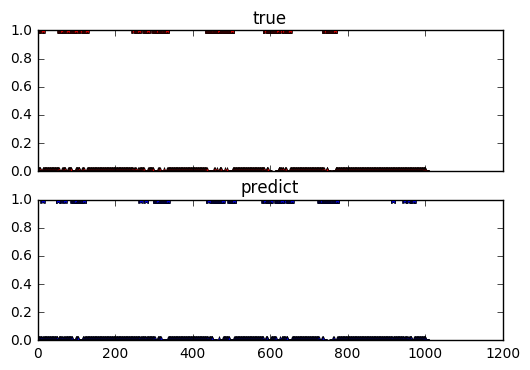

[[694  77]
 [108 123]]
Specifity=0.900129701686	Sensitivity=0.532467532468
true: 27 fogs
pred: 31 fogs


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np
from sklearn import metrics
from utils import *
import warnings

warnings.filterwarnings("ignore")
features = load_feature_by_user()
feature_train = pd.DataFrame(features[1]).append(pd.DataFrame(features[0]))
feature_test = pd.DataFrame(features[2])
X_train = np.array(feature_train.iloc[:, :-1])
y_train = np.array(feature_train.iloc[:, -1])
X_test = np.array(feature_test.iloc[:, :-1])
y_test = np.array(feature_test.iloc[:, -1])
y_all = y_train
X_all = X_train
X_hmm = []
lengths_hmm = []
n = 6
for index in range(0, len(y_all)):
    if y_all[index] == 0:
        continue
    else:
        cur = np.array(X_all[index - n:index, :]).tolist()
        X_hmm.extend(cur)
        lengths_hmm.append(n)

X_hmm_0, lengths_hmm_0 = get_random_samples(X_all, y_all, len(lengths_hmm), n)
hmm_0 = hmm.GMMHMM(n_components=3, n_mix=20)
hmm_0.fit(X=X_hmm_0, lengths=lengths_hmm_0)
hmm_1 = hmm.GMMHMM(n_components=3, n_mix=20)
hmm_1.fit(X=X_hmm, lengths=lengths_hmm)

y_true = []
y_pred = []
for index in range(0, X_test.shape[0]):
    if index <= n:
        sample = X_test[:index + 1, :]
    else:
        sample = X_test[index - n:index, :]
    y_true.append(y_test[index])
    result_1 = hmm_1.score(sample)
    result_0 = hmm_0.score(sample)
    if result_0 > result_1:
        y_pred.append(0)
    else:
        y_pred.append(1)
cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
see_result_by_img(y_true, y_pred)
print_result(cm)
print("true: {} fogs".format(find_fog(y_true)))
print("pred: {} fogs".format(find_fog(y_pred)))

# 静态方法

2735 158


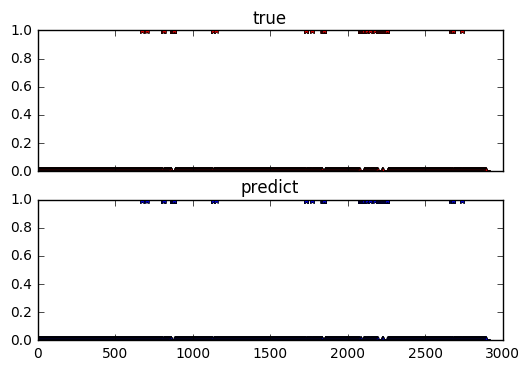

[[271   3]
 [  7   9]]
Specifity=0.989051094891	Sensitivity=0.5625


In [30]:
from sklearn import tree, metrics, ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import NearMiss
import numpy as np
import pandas as pd
import random 
feature_1 = pd.read_csv('./features/S01R01.txt', index_col=0)
feature_2 = pd.read_csv('./features/S01R02.txt', index_col=0)
feature_S01 = feature_1.append(feature_2)
feature_S02_1 = pd.read_csv('./features/S02R01.txt', index_col=0)
feature_S02_2 = pd.read_csv('./features/S02R02.txt', index_col=0)
feature_S02 = feature_S02_1.append(feature_S02_2)
feature_S03_1 = pd.read_csv('./features/S03R01.txt', index_col=0)
feature_S03_2 = pd.read_csv('./features/S03R02.txt', index_col=0)
feature_S03_3 = pd.read_csv('./features/S03R03.txt', index_col=0)
feature_S03 = feature_S03_1.append(feature_S03_2).append(feature_S03_3)
feature_train = feature_1
feature_test = feature_S03
X_train = np.array(feature_train.iloc[:, :-1])
y_train = np.array(feature_train.iloc[:, -1])
X_test = np.array(feature_test.iloc[:, :-1])
y_test = np.array(feature_test.iloc[:, -1])
y_all = y_train
X_all = X_train

#数据均衡
nm1 = NearMiss(version=1)
X_sub, y_sub = nm1.fit_sample(X_all,y_all)
X_0 = X_all[y_all==0]
y_0 = y_all[y_all==0]
X_1 = X_all[y_all==1]
y_1 = y_all[y_all==1]
print len(y_0),len(y_1)
X_add = []
y_add = []
wanted_num = 8*np.array(X_1).shape[0]
for i in range(wanted_num):
    index = random.randint(0,len(y_0)-1)
    X_add.append(X_0[index])
    y_add.append(0)
X_sub = np.vstack([np.array(X_add),X_1])
y_sub = np.hstack([np.array(y_add),y_1])

#分类器：随机森林
clf = ensemble.RandomForestClassifier()
#分类器：决策树
# clf = tree.DecisionTreeClassifier()

#k-fold 交叉验证
# scores = cross_val_score(clf, X_all, y_all, cv=5)
# print scores,scores.mean(),scores.std()

#分为测试集和训练集
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.1, random_state=0)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.1, random_state=0)
X_train = np.vstack([np.array(X_0_train),np.array(X_1_train)])
y_train = np.hstack([np.array(y_0_train),np.array(y_1_train)])
X_test = np.vstack([np.array(X_0_test),np.array(X_1_test)])
y_test = np.hstack([np.array(y_0_test),np.array(y_1_test)])
#训练
clf.fit(X=X_train, y=y_train)
#测试
y_pred = clf.predict(X=X_test)
#评估测试结果
cm = metrics.confusion_matrix(y_test, y_pred=y_pred)
#测试全集
y_all_pred = clf.predict(X=X_all)
# cm = metrics.confusion_matrix(y_true=y_all, y_pred=y_all_pred)
see_result_by_img(y_true=y_all,y_pred=y_all_pred)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
print cm
print("Specifity={}\tSensitivity={}".format(float(TN)/(TN+FP),float(TP)/(TP+FN)))

# print metrics.f1_score(y_test, y_pred)
# print metrics.recall_score(y_test, y_pred)
# print metrics.precision_score(y_test, y_pred)

# X_full = np.array(feature_1.iloc[:, :-1])
# y_full = np.array(feature_1.iloc[:, -1])
# y_full_predict = clf.predict(X_full)
# print metrics.confusion_matrix(y_full, y_pred=y_full_predict)
# print metrics.precision_score(y_full, y_pred=y_full_predict)

In [4]:
pd.DataFrame([np.transpose(y_pred),np.transpose(y_true)]).to_csv('./result.csv')